In [24]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from typing import TypedDict,Annotated
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode,tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
import requests


In [2]:
!pip install langchain-community


  Using cached langchain_community-0.4.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached langchain_classic-1.0.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached aiohttp-3.13.3-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.1 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.12.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.3-py3-none-any.whl.metadata (9.7 kB)
  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.8.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached propcache-0.4.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached yarl-1.22.0-cp310-cp310-ma

In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI()

In [10]:
!pip install -U ddgs

  Using cached ddgs-9.10.0-py3-none-any.whl.metadata (12 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached fake_useragent-2.2.0-py3-none-any.whl.metadata (17 kB)
  Using cached h2-4.3.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached socksio-1.0.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached hyperframe-6.1.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached hpack-4.1.0-py3-none-any.whl.metadata (4.6 kB)
Using cached ddgs-9.10.0-py3-none-any.whl (40 kB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)
Using cached fake_useragent-2.2.0-py3-none-any.whl (161 kB)
Using cached h2-4.3.0-py3-none-any.whl (61 kB)
Using cached hpack-4.1.0-py3-none-any.whl (34 kB)
Using cached hyperframe-6.1.0-py3-none-any.whl (13 kB)
Using cached socksio-1.0.0-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 8.2 MB/s  0:00:01 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 8.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━

In [11]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


In [12]:
@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=X9ZY4CGYAVG57XSV"
    r = requests.get(url)
    return r.json()

In [14]:
#Make tool list
tools = [get_stock_price,search_tool,calculator]

#Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [15]:
#state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [16]:
# graph nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  # Executes tool calls

In [17]:
# graph structure
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [18]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")    

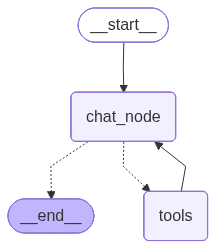

In [19]:

chatbot = graph.compile()

chatbot

In [20]:
# Regular chat
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)


Hello! How can I assist you today?


In [21]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

The result of the operation 2 * 3 is 6.


In [25]:
 #Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out["messages"][-1].content)

The current stock price of Apple (AAPL) is $255.78.


In [26]:
# Chat requiring tool
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)


The current stock price of Apple (AAPL) is $255.78. 
To purchase 50 shares, it would cost $12,789.
